# Payments Dataset EDA

This notebook explores the synthetic payments dataset generated in Stage 1.

Objectives:
- Understand schema, distributions, and seasonality
- Examine merchant, country, and device patterns
- Inspect fraud labels vs amount and time-of-day
- Produce summary tables for downstream analytics


In [1]:
# Imports
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

pd.set_option('display.max_columns', None)
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_context('talk')

# Paths
PROJECT_ROOT = os.path.abspath(os.path.join(os.getcwd(), '..'))
DATA_PATH = os.path.join(PROJECT_ROOT, 'data', 'payments.csv')

# Load
df = pd.read_csv(DATA_PATH, parse_dates=['timestamp'])
print(f"Rows: {len(df):,} | Columns: {len(df.columns)}")
df.head()


Rows: 10,000 | Columns: 11


,transaction_id,user_id,segment,country,merchant,category,amount,timestamp,device_type,is_refunded,is_fraudulent
0,517136535526,208,SMB,AR,Microsoft,electronics,126.02,2023-01-01 01:04:39+00:00,tablet,False,False
1,459867756078,183,consumer,US,Telcel,telco,48.31,2023-01-01 03:08:19+00:00,tablet,True,False
2,522685548627,155,consumer,BR,Oxxo,retail,10.56,2023-01-01 08:52:04+00:00,mobile,True,False
3,328351309961,89,consumer,CL,Amazon,e-commerce,43.70,2023-01-01 11:25:07+00:00,desktop,True,False
4,768956878622,921,merchant,MX,Airbnb,travel,139.69,2023-01-01 12:43:28+00:00,mobile,False,False


In [2]:
# Overview & schema
print(df.dtypes)
print()
print("Missing values per column:\n", df.isna().sum())

summary = df.describe(include='all')
summary

transaction_id                  int64
user_id                         int64
segment                        object
country                        object
merchant                       object
category                       object
amount                        float64
timestamp         datetime64[ns, UTC]
device_type                    object
is_refunded                      bool
is_fraudulent                    bool
dtype: object

Missing values per column:
 transaction_id    0
user_id           0
segment           0
country           0
merchant          0
category          0
amount            0
timestamp         0
device_type       0
is_refunded       0
is_fraudulent     0
dtype: int64


,transaction_id,user_id,segment,country,merchant,category,amount,timestamp,device_type,is_refunded,is_fraudulent
count,1.000000e+04,10000.000000,10000,10000,10000,10000,10000.000000,10000,10000,10000,10000
unique,NaN,NaN,3,5,23,12,NaN,NaN,3,2,2
top,NaN,NaN,consumer,US,Amazon,e-commerce,NaN,NaN,mobile,True,False
freq,NaN,NaN,7992,5991,851,2517,NaN,NaN,6487,7582,9981
mean,4.982021e+11,486.577500,NaN,NaN,NaN,NaN,46.653117,2024-05-30 07:54:34.580599808+00:00,NaN,NaN,NaN
min,1.055879e+09,1.000000,NaN,NaN,NaN,NaN,0.700000,2023-01-01 01:04:39+00:00,NaN,NaN,NaN
25%,2.460039e+11,228.000000,NaN,NaN,NaN,NaN,10.860000,2023-09-19 20:27:07.750000128+00:00,NaN,NaN,NaN
50%,4.987962e+11,489.000000,NaN,NaN,NaN,NaN,21.745000,2024-05-26 20:38:21+00:00,NaN,NaN,NaN
75%,7.516287e+11,720.000000,NaN,NaN,NaN,NaN,48.500000,2025-02-08 22:59:05+00:00,NaN,NaN,NaN
max,9.997532e+11,1000.000000,NaN,NaN,NaN,NaN,1346.090000,2025-10-27 22:19:06+00:00,NaN,NaN,NaN


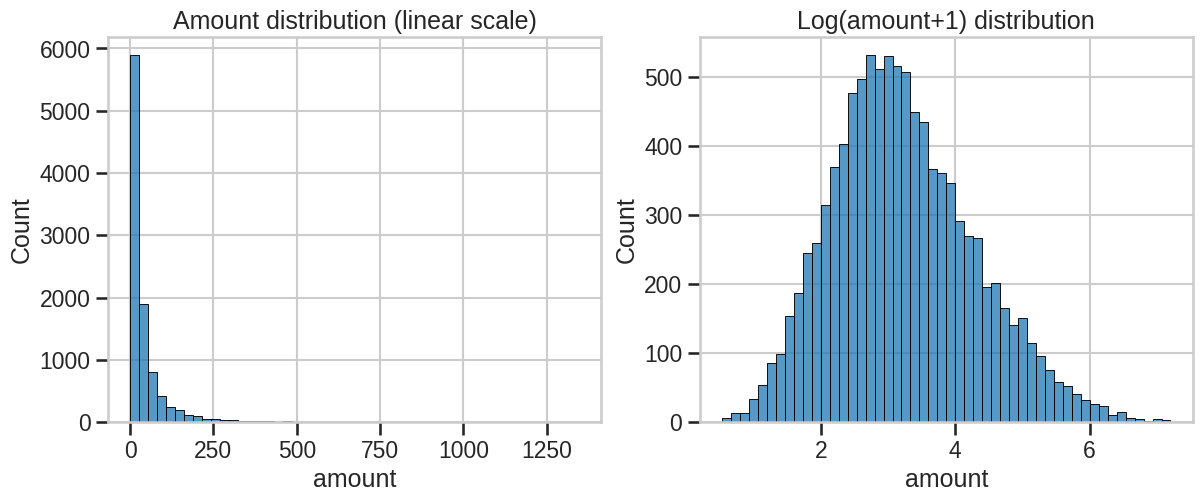

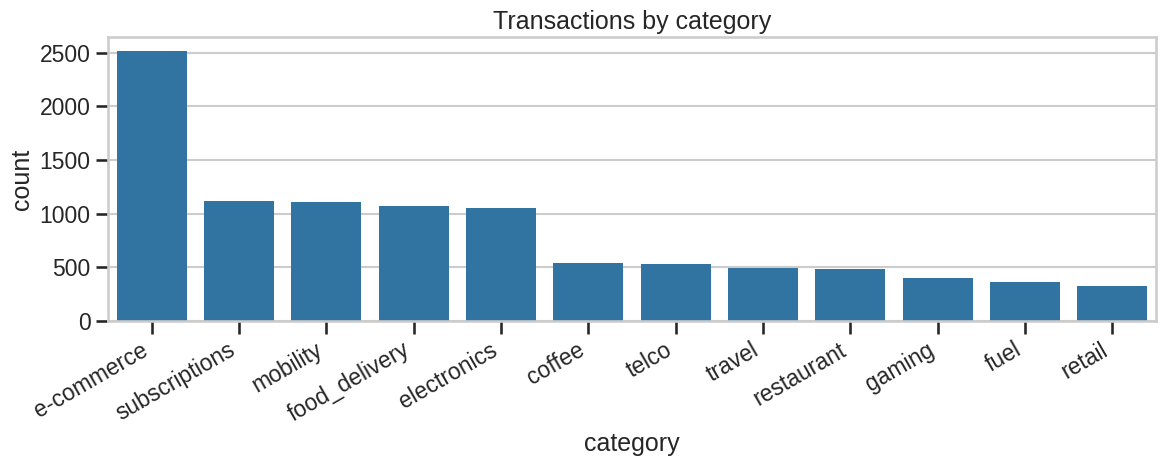

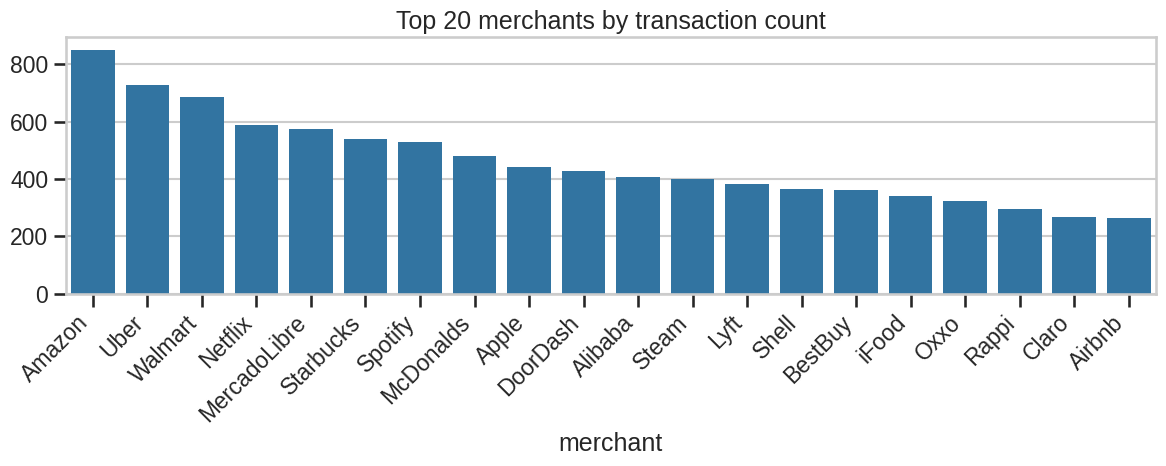

In [3]:
# Distributions
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

sns.histplot(df['amount'], bins=50, ax=axes[0])
axes[0].set_title('Amount distribution (linear scale)')

sns.histplot(np.log1p(df['amount']), bins=50, ax=axes[1])
axes[1].set_title('Log(amount+1) distribution')
plt.show()

# Category share
plt.figure(figsize=(12, 5))
sns.countplot(data=df, x='category', order=df['category'].value_counts().index)
plt.xticks(rotation=30, ha='right')
plt.title('Transactions by category')
plt.tight_layout()
plt.show()

# Merchant frequency (top 20)
plt.figure(figsize=(12, 5))
top_merchants = df['merchant'].value_counts().head(20)
sns.barplot(x=top_merchants.index, y=top_merchants.values)
plt.xticks(rotation=45, ha='right')
plt.title('Top 20 merchants by transaction count')
plt.tight_layout()
plt.show()


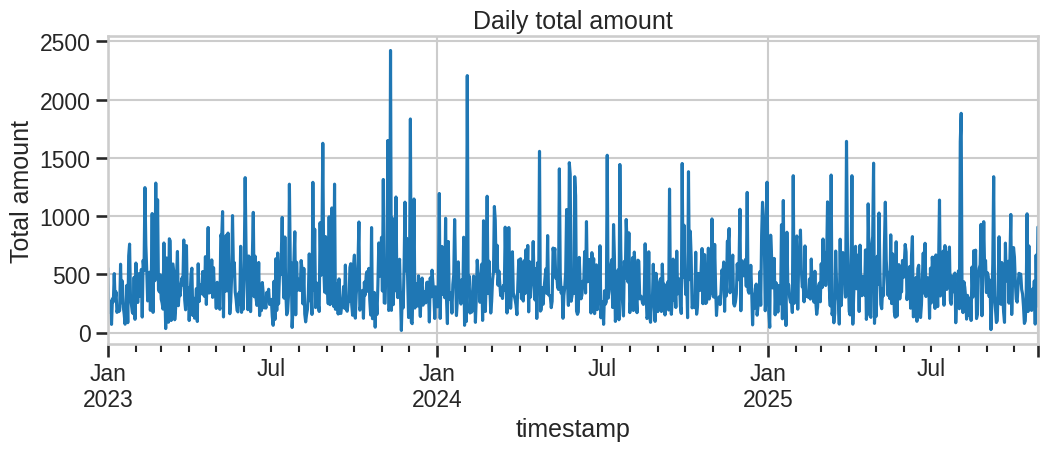

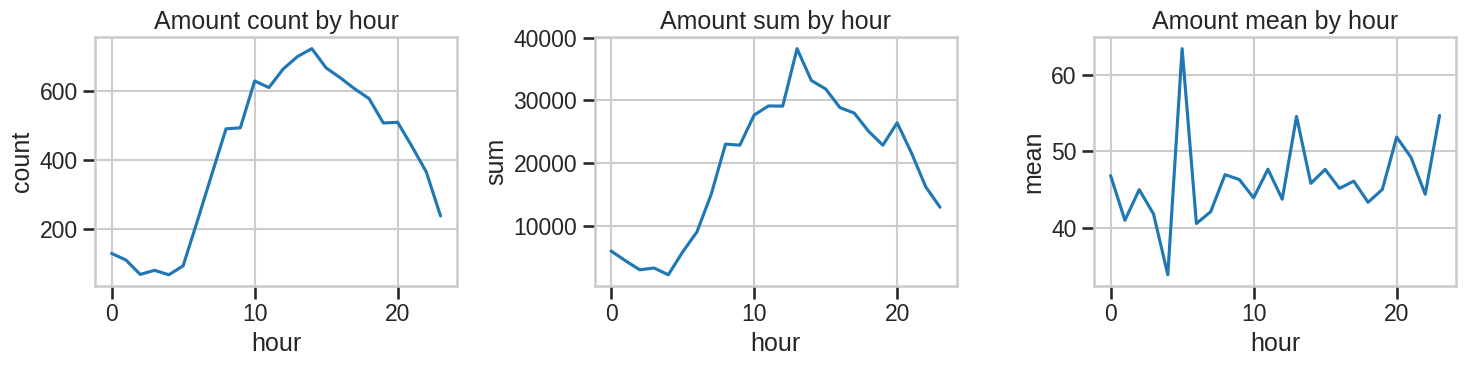

In [4]:
# Time series views
s = df.set_index('timestamp').sort_index()

# By day
by_day = s['amount'].resample('D').sum()
ax = by_day.plot(figsize=(12,4), title='Daily total amount')
ax.set_ylabel('Total amount')
plt.show()

# By hour of day
s['hour'] = s.index.hour
hourly = s.groupby('hour')['amount'].agg(['count','sum','mean'])
fig, axes = plt.subplots(1, 3, figsize=(15,4))
for ax, col in zip(axes, ['count','sum','mean']):
    sns.lineplot(x=hourly.index, y=hourly[col], ax=ax)
    ax.set_title(f'Amount {col} by hour')
plt.tight_layout()
plt.show()


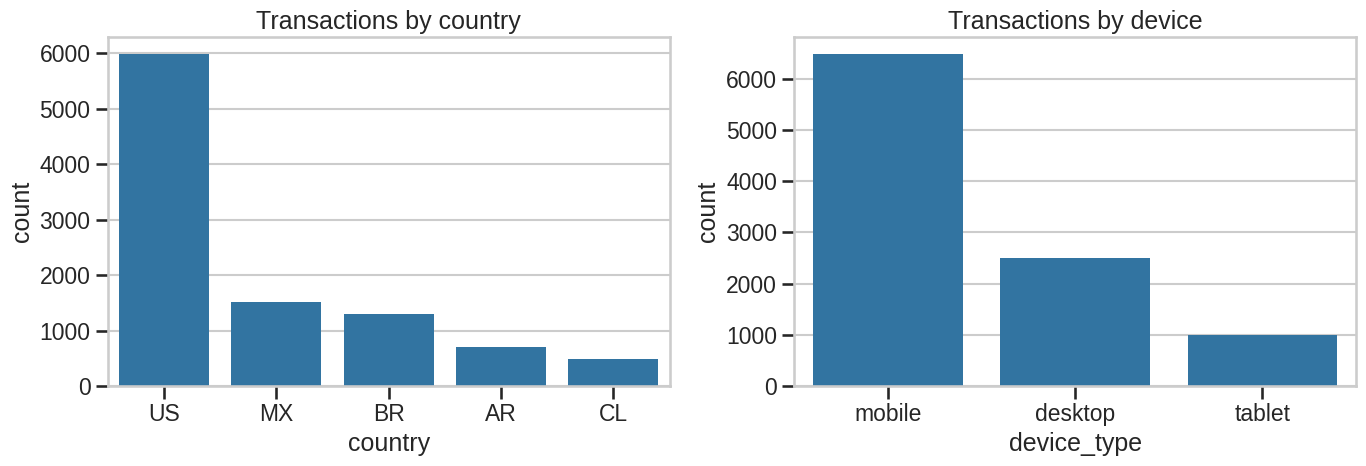

device_type  desktop  mobile  tablet
country                             
AR             46.58   40.59   40.39
BR             42.64   47.93   45.77
CL             41.45   43.23   27.81
MX             38.58   38.73   33.02
US             51.44   48.77   52.66


In [5]:
# Country and device analysis
fig, axes = plt.subplots(1, 2, figsize=(14,5))

sns.countplot(data=df, x='country', order=df['country'].value_counts().index, ax=axes[0])
axes[0].set_title('Transactions by country')

sns.countplot(data=df, x='device_type', order=df['device_type'].value_counts().index, ax=axes[1])
axes[1].set_title('Transactions by device')
plt.tight_layout()
plt.show()

# Spend per country/device
pivot = df.pivot_table(index='country', columns='device_type', values='amount', aggfunc='mean')
print(pivot.round(2))


Overall fraud rate: 0.190%


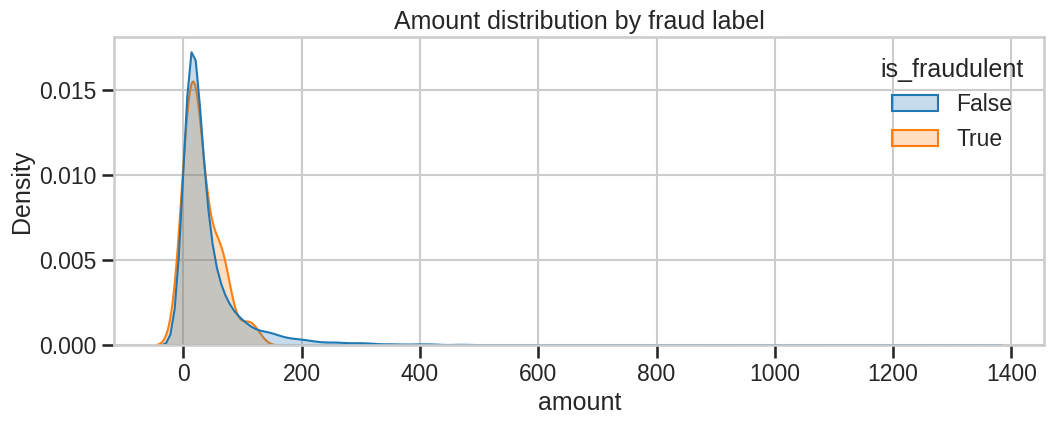

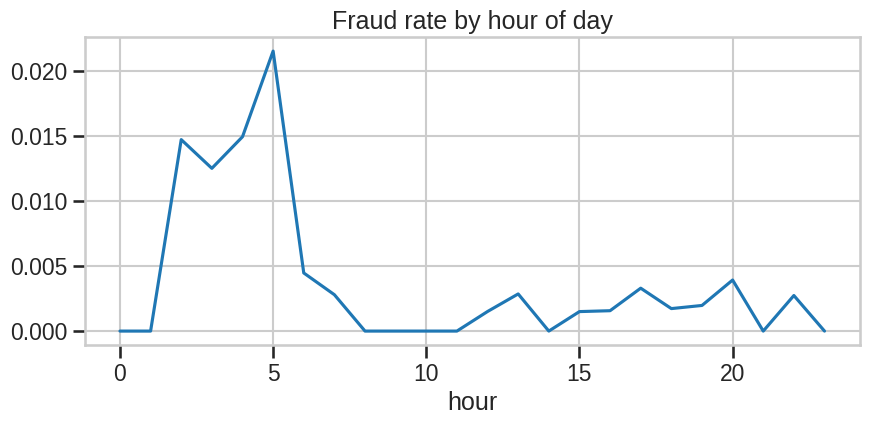

In [6]:
# Fraud analysis
fraud_rate = df['is_fraudulent'].mean()
print(f"Overall fraud rate: {fraud_rate:.3%}")

# Amount vs fraud
plt.figure(figsize=(12,4))
sns.kdeplot(data=df, x='amount', hue='is_fraudulent', common_norm=False, fill=True)
plt.title('Amount distribution by fraud label')
plt.show()

# Hour vs fraud
df['hour'] = df['timestamp'].dt.hour
fraud_by_hour = df.groupby('hour')['is_fraudulent'].mean()
plt.figure(figsize=(10,4))
sns.lineplot(x=fraud_by_hour.index, y=fraud_by_hour.values)
plt.title('Fraud rate by hour of day')
plt.show()


/tmp/ipykernel_4638/1014232974.py:5: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_by_amount = df.groupby(amount_bins)['is_fraudulent'].mean().reset_index()


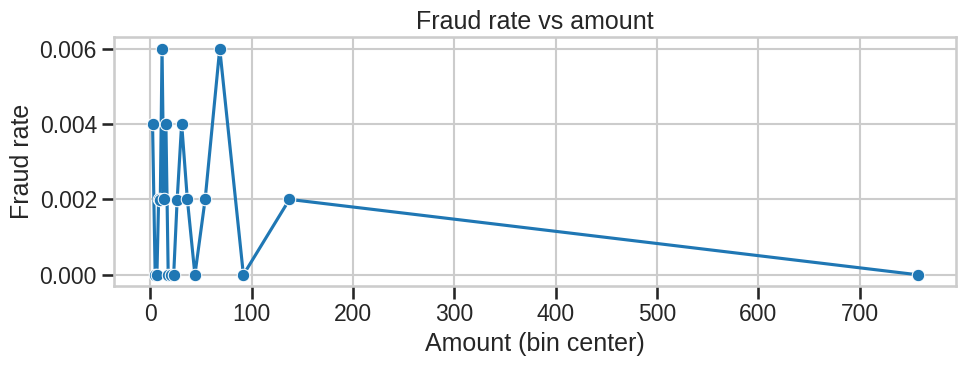

,amount_bin,is_fraudulent,bin_center
0,"(0.699, 4.11]",0.004000,2.4045
1,"(4.11, 5.879]",0.000000,4.9945
2,"(5.879, 7.559]",0.000000,6.7190
3,"(7.559, 9.228]",0.002000,8.3935
4,"(9.228, 10.86]",0.001996,10.0440


In [8]:
# Fraud rate vs amount (binned)
# Use quantile bins to get stable counts per bin
amount_bins = pd.qcut(df['amount'], q=min(20, df['amount'].nunique()), duplicates='drop')
amount_bins.name = 'amount_bin'
rate_by_amount = df.groupby(amount_bins)['is_fraudulent'].mean().reset_index()
rate_by_amount['bin_center'] = rate_by_amount['amount_bin'].apply(lambda iv: (iv.left + iv.right) / 2)

plt.figure(figsize=(10,4))
sns.lineplot(data=rate_by_amount, x='bin_center', y='is_fraudulent', marker='o')
plt.xlabel('Amount (bin center)')
plt.ylabel('Fraud rate')
plt.title('Fraud rate vs amount')
plt.tight_layout()
plt.show()

rate_by_amount.head()


/tmp/ipykernel_4638/2975932475.py:10: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rate_by_velocity = df_velocity.groupby(velocity_bins)['is_fraudulent'].mean().reset_index()


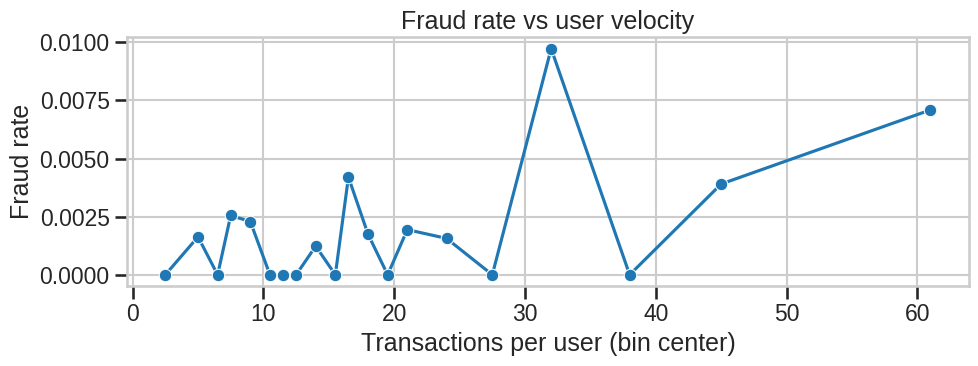

,velocity_bin,is_fraudulent,bin_center
0,"(0.999, 4.0]",0.000000,2.4995
1,"(4.0, 6.0]",0.001631,5.0000
2,"(6.0, 7.0]",0.000000,6.5000
3,"(7.0, 8.0]",0.002551,7.5000
4,"(8.0, 10.0]",0.002288,9.0000


In [9]:
# Fraud rate vs user velocity (binned)
# Compute transactions per user (velocity)
user_tx_counts = df.groupby('user_id')['transaction_id'].count().rename('tx_per_user')
df_velocity = df.merge(user_tx_counts, left_on='user_id', right_index=True)

# Bin velocity and compute fraud rate per bin
max_bins = min(20, df_velocity['tx_per_user'].nunique())
velocity_bins = pd.qcut(df_velocity['tx_per_user'], q=max_bins, duplicates='drop')
velocity_bins.name = 'velocity_bin'
rate_by_velocity = df_velocity.groupby(velocity_bins)['is_fraudulent'].mean().reset_index()
rate_by_velocity['bin_center'] = rate_by_velocity['velocity_bin'].apply(lambda iv: (iv.left + iv.right) / 2)

plt.figure(figsize=(10,4))
sns.lineplot(data=rate_by_velocity, x='bin_center', y='is_fraudulent', marker='o')
plt.xlabel('Transactions per user (bin center)')
plt.ylabel('Fraud rate')
plt.title('Fraud rate vs user velocity')
plt.tight_layout()
plt.show()

rate_by_velocity.head()


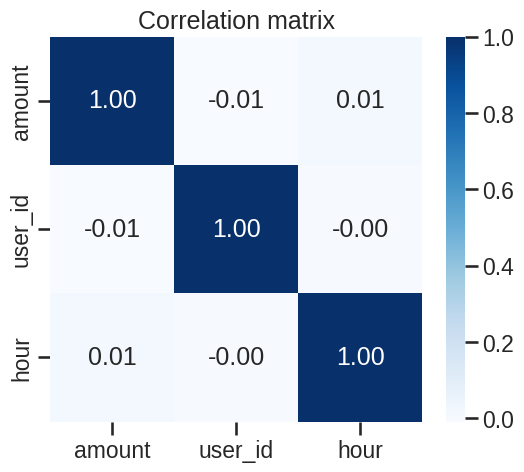

,tx_count,total_amount,avg_amount,fraud_rate
merchant,,,,
Amazon,851,28881.65,33.94,0.0035
Uber,728,12742.69,17.50,0.0027
Walmart,686,24177.42,35.24,0.0029
Netflix,588,6618.59,11.26,0.0000
MercadoLibre,574,19230.28,33.50,0.0000
Starbucks,541,4456.17,8.24,0.0000
Spotify,530,6425.07,12.12,0.0075
McDonalds,480,10589.95,22.06,0.0021
Apple,441,75567.62,171.36,0.0000


In [7]:
# Correlations
numeric_cols = ['amount', 'user_id', 'hour']

corr = df[numeric_cols].corr(numeric_only=True)
plt.figure(figsize=(6,5))
sns.heatmap(corr, annot=True, fmt='.2f', cmap='Blues')
plt.title('Correlation matrix')
plt.show()

# Merchant performance table
merchant_stats = (
    df.groupby('merchant')
      .agg(tx_count=('transaction_id','count'),
           total_amount=('amount','sum'),
           avg_amount=('amount','mean'),
           fraud_rate=('is_fraudulent','mean'))
      .sort_values('tx_count', ascending=False)
      .head(20)
)
merchant_stats.round({'total_amount': 2, 'avg_amount': 2, 'fraud_rate': 4})


## Notes
- This EDA is intended to validate the realism of the generator.
- For reproducibility, ensure the dataset was generated with a known seed.
- Extend this notebook with charts relevant to your downstream tasks.
